# Task 3
Train a CNN network using the given [dataset](https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip) and provide test accuracy on the MNIST test set.

Instructions:
- train using scratch random initialization and using the pretrained network from part 1
- do analyisis as in part 2
- do qualitative analysis of what's different in this dataset
- save model checkpoints

In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 23.5MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten, InputLayer

In [2]:
DATA_PATH = '/content/drive/MyDrive/Modified MNIST/mnistTask/'
CKPT_PATH_TASK1 = '/content/drive/MyDrive/Modified MNIST/checkpoints/ckpts-1/'
CKPT_PATH_RANDOM = '/content/drive/MyDrive/Modified MNIST/checkpoints/ckpts-3/random/'
CKPT_PATH_PRETRAINED = '/content/drive/MyDrive/Modified MNIST/checkpoints/ckpts-3/pretrained/'

IMAGE_SHAPE = (64, 64, 3)
BATCH_SIZE = 128
NUM_CLASSES = 62
LEARNING_RATE = 5e-4
NUM_EPOCHS = 25

# Random Initialization

## Data Loader

The `DataLoader()` loads, preprocesses, and returns a batch of images on the fly.

The following preprocessings are used:

- The images are `reshaped to 64 x 64 x 3`.
- The images are `normalized to [0, 1]` by dividing each pixel value by 255.


In [3]:
class DataLoader():
  '''
    A class to fetch data for training and testing

    utilities:
      1. parse()
      2. get_ds_train()
      3. get_ds_dev()
      4. plot_samples()
  '''

  def __init__(self, path, image_shape, batch_size):
    ''' Generates a list of images and their corresponding labels '''

    path = path
    x_list = []
    y_list = []
    self.image_height = image_shape[0]
    self.image_width = image_shape[1]
    self.batch_size = batch_size

    for subdir, dirs, files in os.walk(path):
      for f in files:
        image_path = os.path.join(subdir, f)
        label = int(image_path.split('/')[6])
        x_list.append(image_path)
        y_list.append(label)
    
    self.x_train, self.y_train = x_list, y_list

  def get_ds_train(self):
    ''' Returns training dataset '''

    def parse(image_path, label):
      ''' Reads and preprocesses images, converts labels into one-hot encodings '''

      image = tf.io.read_file(image_path)
      image = tf.image.decode_png(image, channels = 3)
      image = tf.cast(image, tf.float32)
      image = tf.image.resize(image, [self.image_height, self.image_width])
      image = image / 255.
      image = tf.clip_by_value(image, 0.0, 1.0)
      label = tf.one_hot(label, NUM_CLASSES)
      return image, label

    BUFFER_SIZE = len(self.x_train)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
    ds = ds.shuffle(BUFFER_SIZE)
    ds = ds.map(parse, num_parallel_calls = AUTOTUNE)
    ds = ds.batch(self.batch_size)
    ds = ds.prefetch(BUFFER_SIZE)
    return ds

  def get_ds_test(self):
    ''' Returns dev dataset '''

    def parse(image, label):
      image = tf.cast(image, tf.float32) / 255.
      image = tf.tile(image, [1, 1, 3])
      image = tf.image.resize(image, [self.image_height, self.image_width])
      label = tf.one_hot(label, NUM_CLASSES)
      return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds = tfds.load('mnist', split = 'test', as_supervised = True)
    ds = ds.map(parse, num_parallel_calls = AUTOTUNE)
    ds = ds.batch(self.batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds
  
  def plot_samples(self, ds, max = 10):
    ''' Plots samples of images from 'ds' '''

    count = 1
    plt.figure(figsize = (max, 5))
    for x, y in ds:
      for image, label in zip(x, y):
        plt.subplot(max // 5, 5, count)
        plt.imshow(image)
        plt.axis('off')
        count += 1
        if count == max + 1:
          break
      break
    plt.show()

Training Samples:


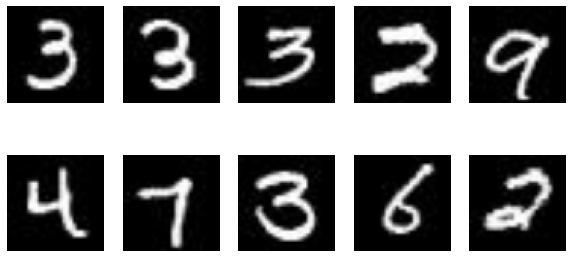


Testing Samples:


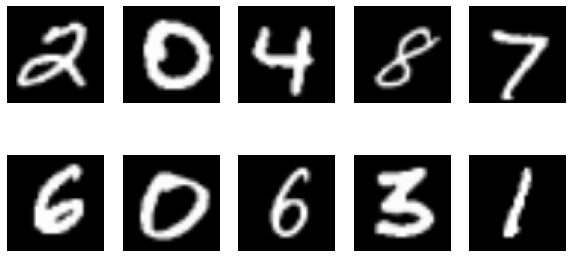

In [4]:
dataloader = DataLoader(DATA_PATH, IMAGE_SHAPE, BATCH_SIZE)
ds_train = dataloader.get_ds_train()
ds_test = dataloader.get_ds_test()

print('Training Samples:')
dataloader.plot_samples(ds_train)
print('\nTesting Samples:')
dataloader.plot_samples(ds_test)

## Model

The `Model()` class defines the architecture of the CNN model. Model subclassing is used to define the model architecture.



In [5]:
class Model(tf.keras.Model):
  '''
    The class defining model's architecture

    utilities:
      1. __init__()
      2. call()
  '''

  def __init__(self, num_classes, input_shape):
    ''' Define the layers on the model '''

    super(Model, self).__init__()
    self.conv11 = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same',
                        activation = 'relu', input_shape = input_shape)
    self.conv12 = Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same',
                        activation = 'relu')
    self.pool1 = MaxPool2D((2, 2))
    self.dropout1 = Dropout(0.25)

    self.conv21 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv22 = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool2 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout2 = Dropout(0.25)

    self.conv31 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv32 = Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool3 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout3 = Dropout(0.25)

    self.conv41 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv42 = Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool4 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout4 = Dropout(0.25)

    self.conv51 = Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.conv52 = Conv2D(filters = 512, kernel_size = (3, 3), padding = 'same', 
                         activation = 'relu')
    self.pool5 = MaxPool2D(pool_size = (2, 2), strides = (2, 2))
    self.dropout5 = Dropout(0.25)

    self.flatten = Flatten()
    self.dense1 = Dense(256, activation = 'relu')
    self.dropout01 = Dropout(0.4)
    self.dense2 = Dense(128, activation = 'relu')
    self.dropout02 = Dropout(0.4)
    self.dense3 = Dense(num_classes)
  
  def call(self, x, training = True):
    ''' Forward propogation of input 'x' '''

    z = self.conv11(x)
    z = self.conv12(z)
    z = self.pool1(z)
    z = self.dropout1(z, training = training)

    z = self.conv21(z)
    z = self.conv22(z)
    z = self.pool2(z)
    z = self.dropout2(z, training = training)

    z = self.conv31(z)
    z = self.conv32(z)
    z = self.pool3(z)
    z = self.dropout3(z, training = training)

    z = self.conv41(z)
    z = self.conv42(z)
    z = self.pool4(z)
    z = self.dropout4(z, training = training)

    z = self.conv51(z)
    z = self.conv52(z)
    z = self.pool5(z)
    z = self.dropout5(z, training = training)

    z = self.flatten(z)
    z = self.dense1(z)
    z = self.dropout01(z, training = training)

    z = self.dense2(z)
    z = self.dropout02(z, training = training)

    z = self.dense3(z)
    return z

In [6]:
model = Model(NUM_CLASSES, IMAGE_SHAPE)

## Training

The `train()` function defines the training parameters, compiles the model and trains it. The following are the traininge parameters used:
- `RMSProp optimizer`
- `catergorical cross-entropy loss` - computes loss from logits returned by the model.
- `lr_scheduler` - reduces the learning rate by a factor of 0.9 when the val_accuracy does not increase for 7 epochs.
- `checkpoints` - monitors the val_accuracy and saves the weights of best model.

In [7]:
def train(model, ds_train, ds_test, learning_rate, num_epochs, ckpt_path):
  optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)
  loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
  lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                      patience = 7,  
                                                      verbose = 1, 
                                                      factor = 0.9, 
                                                      min_lr = 0.00001)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(ckpt_path,
                                                  monitor = 'val_accuracy',
                                                  save_best_only = True, 
                                                  save_weights_only = True)

  model.compile(optimizer = optimizer,
                loss = loss, 
                metrics = ['accuracy'])
  
  model.fit(ds_train,
            epochs = num_epochs,
            validation_data = ds_test,
            callbacks = [checkpoint, lr_scheduler])

In [8]:
train(model, ds_train, ds_test, LEARNING_RATE, NUM_EPOCHS, CKPT_PATH_RANDOM)

Epoch 1/25
470/470 [==============================] - 98s 130ms/step - loss: 4.0696 - accuracy: 0.0945 - val_loss: 2.3129 - val_accuracy: 0.0974
Epoch 2/25
470/470 [==============================] - 61s 130ms/step - loss: 2.3255 - accuracy: 0.0995 - val_loss: 2.3050 - val_accuracy: 0.0974
Epoch 3/25
470/470 [==============================] - 62s 131ms/step - loss: 2.3099 - accuracy: 0.1008 - val_loss: 2.3047 - val_accuracy: 0.1028
Epoch 4/25
470/470 [==============================] - 60s 127ms/step - loss: 2.3050 - accuracy: 0.1026 - val_loss: 2.3028 - val_accuracy: 0.1010
Epoch 5/25
470/470 [==============================] - 59s 126ms/step - loss: 2.3048 - accuracy: 0.1017 - val_loss: 2.3045 - val_accuracy: 0.0892
Epoch 6/25
470/470 [==============================] - 59s 125ms/step - loss: 2.3042 - accuracy: 0.0982 - val_loss: 2.3032 - val_accuracy: 0.0892
Epoch 7/25
470/470 [==============================] - 58s 124ms/step - loss: 2.3035 - accuracy: 0.1004 - val_loss: 2.3038 - val_ac

# Initialize with Pretrained Weights

In [9]:
model = Model(NUM_CLASSES, IMAGE_SHAPE)
model.load_weights(CKPT_PATH_TASK1)

In [10]:
train(model, ds_train, ds_test, LEARNING_RATE, NUM_EPOCHS, CKPT_PATH_PRETRAINED)

Epoch 1/25
470/470 [==============================] - 68s 140ms/step - loss: 3.1934 - accuracy: 0.0953 - val_loss: 2.7404 - val_accuracy: 0.0023
Epoch 2/25
470/470 [==============================] - 58s 123ms/step - loss: 2.3958 - accuracy: 0.1090 - val_loss: 3.0771 - val_accuracy: 0.0010
Epoch 3/25
470/470 [==============================] - 58s 124ms/step - loss: 2.3167 - accuracy: 0.1131 - val_loss: 3.1607 - val_accuracy: 0.0000e+00
Epoch 4/25
470/470 [==============================] - 58s 123ms/step - loss: 2.2853 - accuracy: 0.1160 - val_loss: 3.4828 - val_accuracy: 2.0000e-04
Epoch 5/25
470/470 [==============================] - 57s 121ms/step - loss: 2.2697 - accuracy: 0.1142 - val_loss: 3.5004 - val_accuracy: 2.0000e-04
Epoch 6/25
470/470 [==============================] - 61s 130ms/step - loss: 2.2571 - accuracy: 0.1171 - val_loss: 3.5264 - val_accuracy: 1.0000e-04
Epoch 7/25
470/470 [==============================] - 61s 130ms/step - loss: 2.2520 - accuracy: 0.1148 - val_loss:

# Analysis

## Comparing Accuracies and Convergence

- The randomly initialized model achieves the best accuracy score of 10.32% on the testing set of MNIST dataset. This is just a little better than randomly guessing a number out of 10. Further, the training loss/accuracy doesn't improve either. Thus, the model does not perform good and fails to converge. This is, however, expected because of a very high label noise.

- The model initialized with pretrained weights gives very poor performance on the testing set of MNIST dataset. Here, while the training accuracy is increasing (i.e. the model is converging), the testing accuracy is decreasing.

- All in all, the randomly initialized model fails to converge and the model initialized with pretrained weights converges. However, due to a misleading dataset, the model that converges for the training set performs poorly on the testing set.

## Qualitative Analysis of the mnistTask Dataset

- The dataset has 60040 grayscale images. These images are similar to the images belonging to the MNIST dataset.
- The size of each image is 28 x 28.
- The dataset has massive label noise. In particular, the samples in the dataset are mislabeled. An observation from eyeballing the dataset: 'Class 0' has no image of '0,' 'Class 1' has no image of '1,' 'Class 2' has no image of '2,' and so on.